## Step 1: BLAST Search

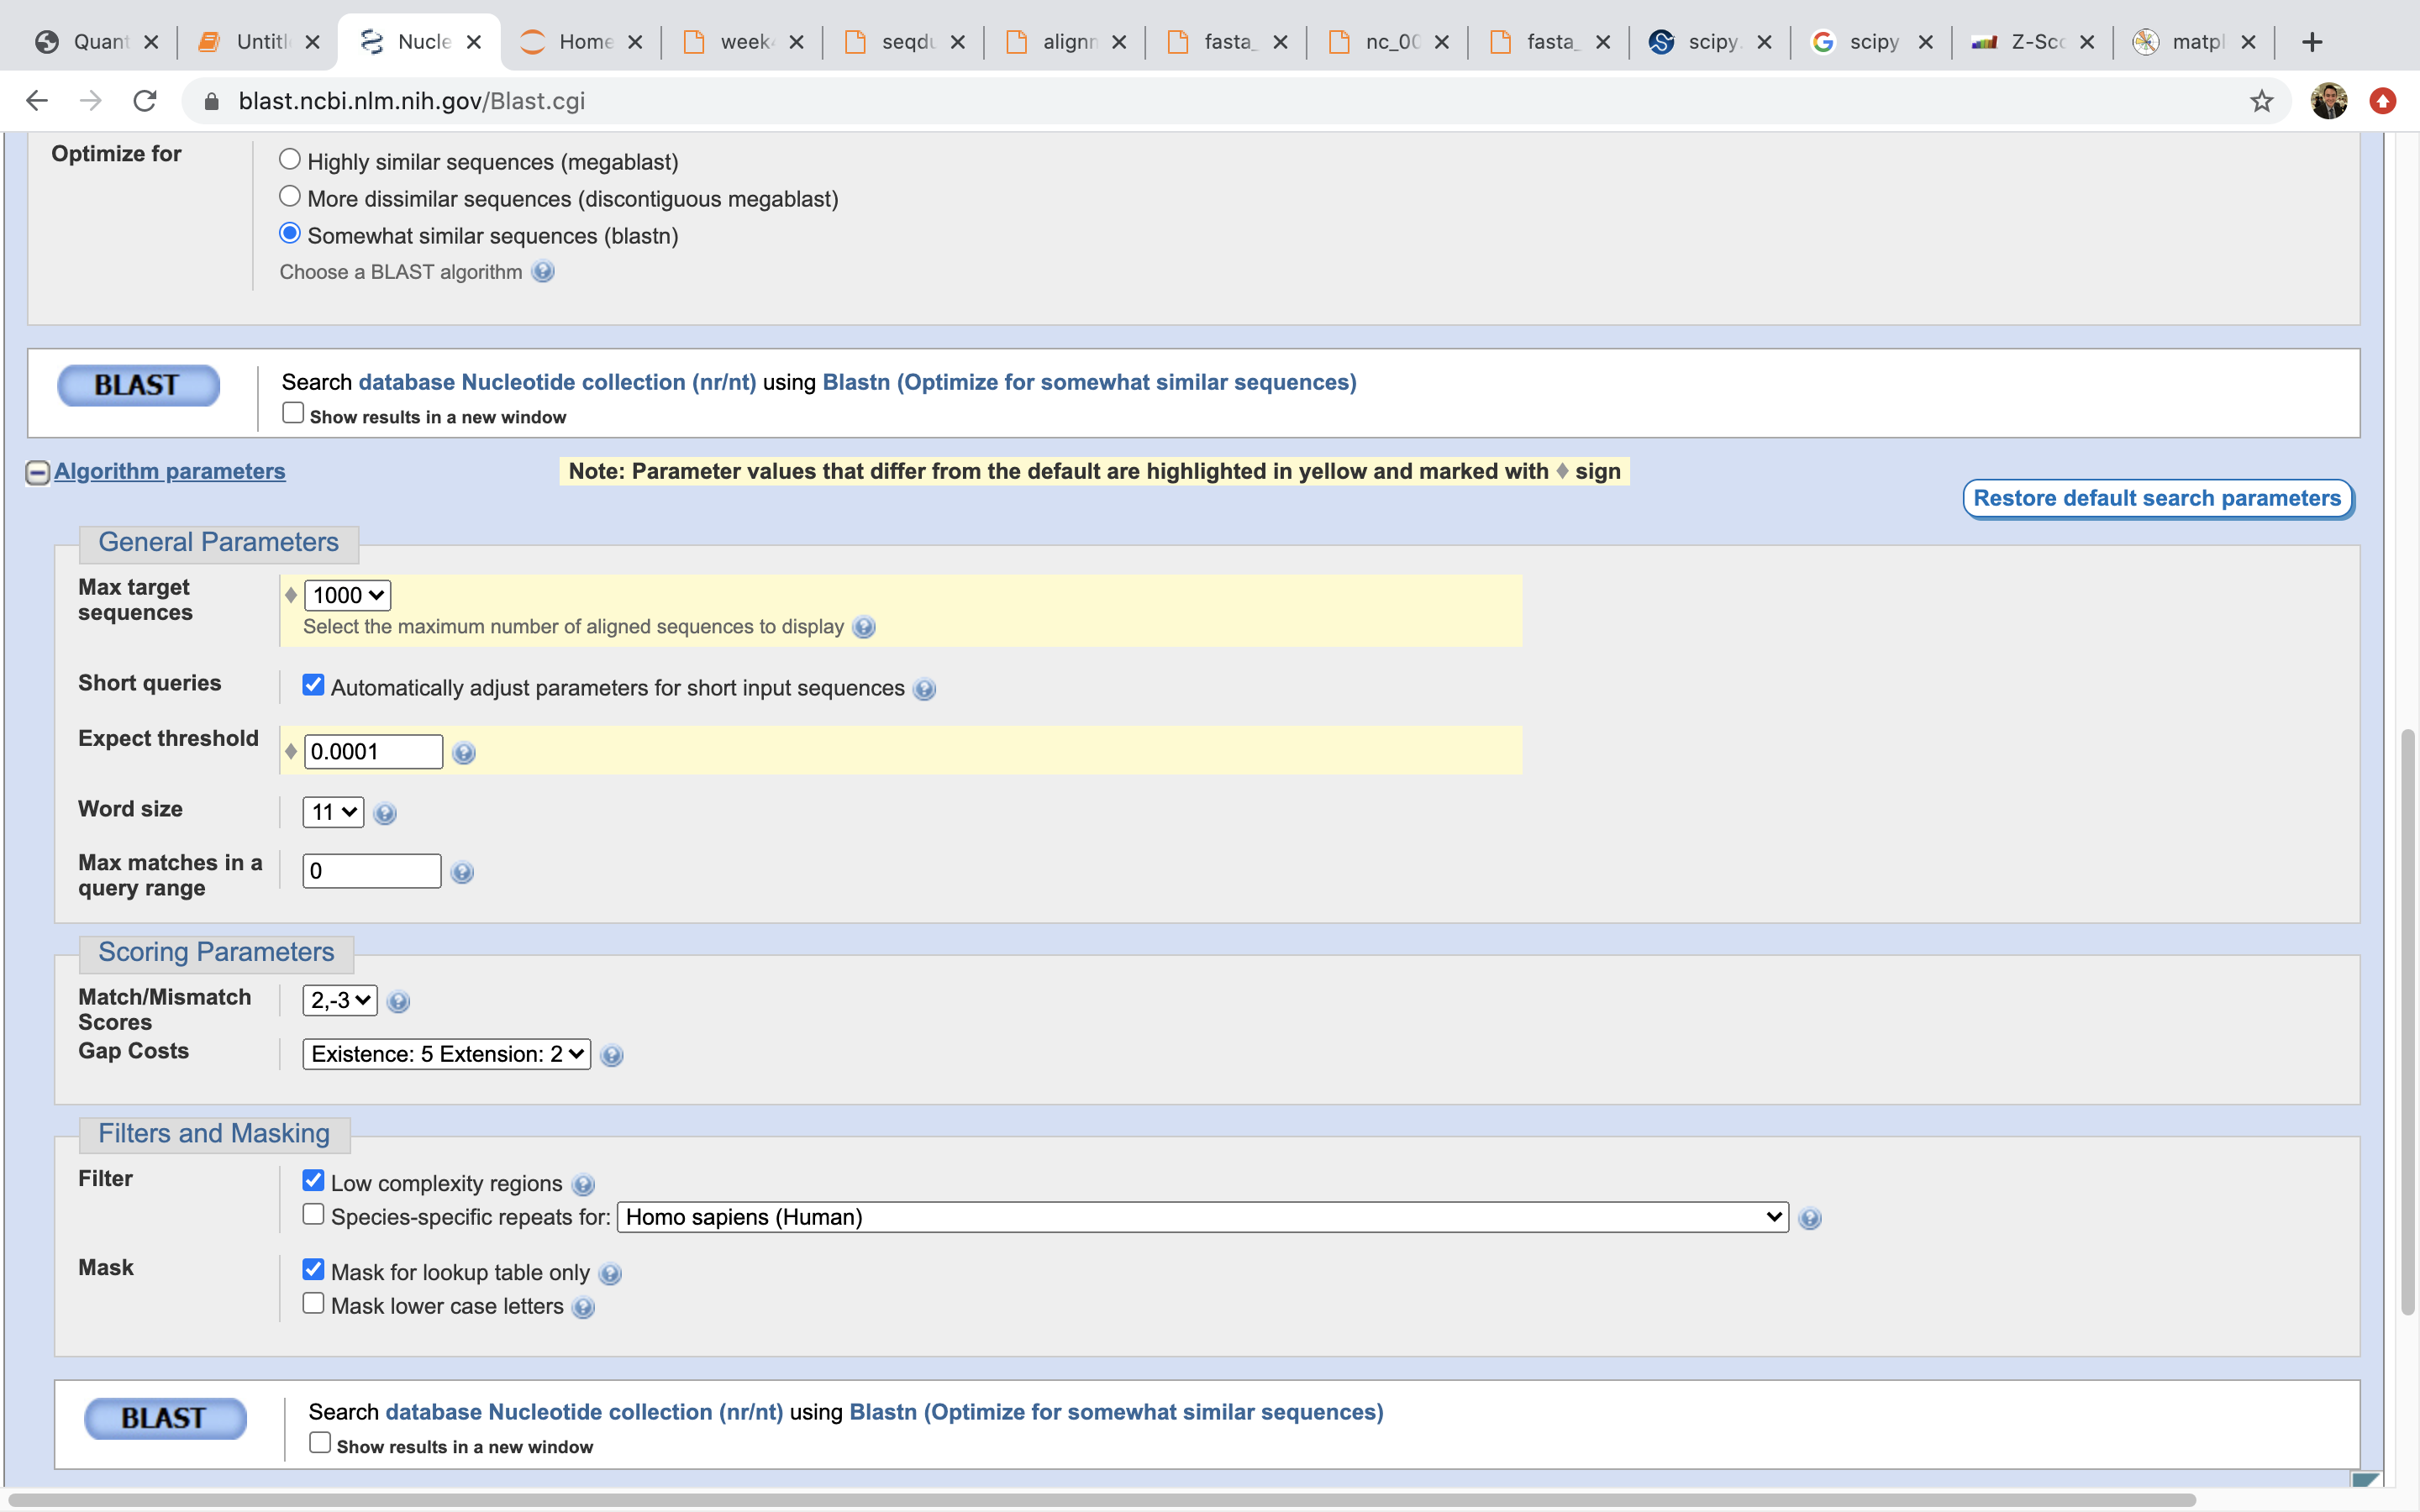

## Step 2: Multiple Sequence Alignment 

In [ ]:
%%bash 
#copied the query sequence into the original seqdump file > seqdump1.fa
transeq seqdump1.fa 
#made filename query.pep 
mafft query.pep > alignment.fa 

## Step 3: Converting back to nucleotides

In [4]:
from fasta_iterator_class import FASTAReader
import math
import matplotlib.pyplot as plt
import scipy.stats as spy
import numpy as np

In [33]:
nt_sequences=FASTAReader(open("seqdump1.fa",'r'))
protein_alignment=FASTAReader(open('alignment.fa'))
nt_alignment=open("nt_alignment.fa","w+")


for nt,prot in zip(nt_sequences,protein_alignment):
    nt_alignment.write(">" + nt[0]+"\n")
    seqwgaps=""
    nt_count=0
    prot_count=0
    protein=prot[1]
    dna=nt[1]
    for x in protein:
        if x =="-":
            seqwgaps+="---" #convert protein gaps into nucleotide gaps
        else:
            seqwgaps+=dna[nt_count:nt_count+3] #fill with corresponding codon
            nt_count+=3
        prot_count+=1
    nt_alignment.write(seqwgaps+"\n")
nt_alignment.close()


## Step 4: Looking for selection 

In [34]:
codontable = {
'ATA':'I', 'ATC':'I', 'ATT':'I', 'ATG':'M',
'ACA':'T', 'ACC':'T', 'ACG':'T', 'ACT':'T',
'AAC':'N', 'AAT':'N', 'AAA':'K', 'AAG':'K',
'AGC':'S', 'AGT':'S', 'AGA':'R', 'AGG':'R',
'CTA':'L', 'CTC':'L', 'CTG':'L', 'CTT':'L',
'CCA':'P', 'CCC':'P', 'CCG':'P', 'CCT':'P',
'CAC':'H', 'CAT':'H', 'CAA':'Q', 'CAG':'Q',
'CGA':'R', 'CGC':'R', 'CGG':'R', 'CGT':'R',
'GTA':'V', 'GTC':'V', 'GTG':'V', 'GTT':'V',
'GCA':'A', 'GCC':'A', 'GCG':'A', 'GCT':'A',
'GAC':'D', 'GAT':'D', 'GAA':'E', 'GAG':'E',
'GGA':'G', 'GGC':'G', 'GGG':'G', 'GGT':'G',
'TCA':'S', 'TCC':'S', 'TCG':'S', 'TCT':'S',
'TTC':'F', 'TTT':'F', 'TTA':'L', 'TTG':'L',
'TAC':'Y', 'TAT':'Y', 'TAA':'_', 'TAG':'_',
'TGC':'C', 'TGT':'C', 'TGA':'_', 'TGG':'W'
}

In [35]:
file=FASTAReader(open("nt_alignment.fa", 'r'))

ref=''
count=0

#put query sequence in string 'ref'
for query in file:
    if count==0:
        ref=query[1]
        break
    count+=1
    
dN=[]
dS=[]
ref_list=[] #make query list to check ref against so it's not included 

for query in file:
    ref_list.append(query[1])

for r in range(0,len(ref),3): #loop through the query sequence by triplets
    loop_dN=0
    loop_dS=0
    
    if ref[r:r+3]=="---": #skip gaps
        pass
    else: 
        nuc1=ref[r:r+3]
        aa1=codontable[nuc1]

        for query in ref_list:
            nuc2=query[r:r+3]
            #don't compare first sequence
            if ref==query:
                pass
            elif nuc2 not in codontable:
                pass
            else:
                aa2=codontable[nuc2]
                if (nuc1 != nuc2) and (aa1==aa2):
                    loop_dS += 1
                elif (nuc1 != nuc2) and (aa1!= aa2):
                    loop_dN += 1

        dN.append(loop_dN)
        dS.append(loop_dS)


In [36]:
D = [] 
for x, y in zip(dN, dS):
    D.append(x - y)

std = np.std(D) #get standard deviations of D 
#print(std)

zscore = []
for i in D:
    zscore.append(i/std) #get zscores with mean of 0

#print(zscore)
    
p_val = (spy.norm.sf(zscore)) * 2 #two-tailed significance test
print(p_val[5])


0.0003836316590933238


Text(0, 0.5, 'log2 dN/dS')

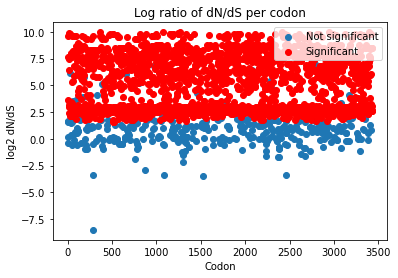

In [37]:
codon=[]
codon_sig = []
dNdS=[]
dNdS_sig  = []

for i in range(len(dN)):
    if dN[i]!=0 and dS[i]!=0 and p_val[i] > 0.05: 
        dNdS.append(math.log((dN[i]/dS[i]),2))
        codon.append(i)
        
    elif dN[i]!=0 and dS[i]!=0 and p_val[i] < 0.05:
        dNdS_sig.append(math.log((dN[i]/dS[i]), 2))
        codon_sig.append(i)

plt.scatter(codon,dNdS, label = "Not significant")
plt.scatter(codon_sig,dNdS_sig, label = "Significant", color = 'red')
plt.title("Log ratio of dN/dS per codon")
plt.legend(loc = 'upper right')
plt.xlabel("Codon")
plt.ylabel("log2 dN/dS")